# 基本配置

In [ ]:
# !pip install -r requirements.txt

## 导入库

In [ ]:
import os
import platform
import zipfile
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import albumentations as A
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

## 设置绘图的中文字体

In [ ]:
# # 设置 matplotlib 支持中文显示
# plt.rcParams['font.sans-serif'] = ['SimHei'] if platform.system() == 'Windows' else ['Heiti TC']
# plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# # 测试代码，显示当前字体设置
# print(f"当前字体设置: {plt.rcParams['font.family']}")

## 使用GPU加速

In [ ]:
# 检查操作系统
if platform.system() == 'Windows':
    # Windows平台
    # 设置TensorFlow使用Nvidia GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # 设置GPU内存增长，避免占用全部GPU内存
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("正在使用 GPU 运行")
        except RuntimeError as e:
            # 打印异常
            print("发生错误：", e)
elif platform.system() == 'Darwin':
    # MacOS平台
    # 检查是否支持Apple M1芯片GPU
    try:
        # 尝试设置TensorFlow以使用Apple M1芯片的GPU
        if tf.config.list_physical_devices('GPU'):
            print("正在使用 Apple M1 GPU 运行")
        else:
            # 如果没有可用的GPU，将使用CPU
            print("正在使用 CPU 运行")
    except Exception as e:
        print("发生错误：", e)
else:
    # 其他平台，默认使用CPU
    print("正在使用 CPU 运行")

- BreaKHis_v1
    - BreaKHis_v1
        - histology_slides
            - breast
                - **benign**
                    - **SOB**
                        - 类型
                            - **患者ID**
                                - 40x
                                - 100x
                                - 200x
                                - 400x
                - **malignant**
                    - **SOB**
                        - 类型
                            - **患者ID**
                                - 40x
                                - 100x
                                - 200x
                                - 400x

# 文件读取

## 解压数据
- Original_dataset 文件夹

In [ ]:
# 检查解压目录是否已存在
if not os.path.exists('./BreaKHis_v1'):
    # 解压 zip 文件
    with zipfile.ZipFile('./dataset.zip') as zip_ref:
        zip_ref.extractall('./')
        print('数据集已解压文件夹')
else:
    print('数据集文件已存在，无需解压。')

## 遍历文件路径

In [ ]:
def process_dataset(root_dir):
    data = {"image_path": [], "label": [], "zoom_level": []}

    # 遍历'benign'和'malignant'文件夹
    for label in ['benign', 'malignant']:
        label_dir = os.path.join(root_dir, label, "SOB")

        # 遍历每个类型的目录
        for type_dir in os.listdir(label_dir):
            type_dir_path = os.path.join(label_dir, type_dir)

            # 遍历每个患者ID的目录
            for patient_id_dir in os.listdir(type_dir_path):
                patient_dir_path = os.path.join(type_dir_path, patient_id_dir)

                # 遍历每个zoom level的目录
                for zoom_level_dir in os.listdir(patient_dir_path):
                    zoom_dir_path = os.path.join(patient_dir_path, zoom_level_dir)

                    # 遍历zoom级别的目录
                    for img_file in os.listdir(zoom_dir_path):
                        img_file_path = os.path.join(zoom_dir_path, img_file)

                        # 将图像路径，对应的zoom level和标签加入到data字典中
                        data["image_path"].append(img_file_path)
                        data["label"].append(label)
                        data["zoom_level"].append(zoom_level_dir)

    # 创建一个基于data的pandas DataFrame
    df = pd.DataFrame(data)
    return df

In [ ]:
root_dir = "./BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
df = process_dataset(root_dir)
df

## 数据集可视化

In [ ]:
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.groupby('zoom_level').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 数据集过滤

In [ ]:
# df_filtered = df[df['zoom_level'] == '40X']
# df = df_filtered
# df

# 数据集划分

## 标签编码
- 将原始数据集中的字符串标签编码为整数

In [ ]:
# 创建一个 LabelEncoder 对象
label_encoder = LabelEncoder()

# 使用 fit_transform 方法将类别标签转换为整数
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# 查看编码后的标签对应的原始标签
print(label_encoder.classes_)
df

## 划分操作

In [ ]:
# 先将原数据集划分为80%的训练集和20%的（验证集+测试集）
train_df, val_test_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'])

# 再将（验证集+测试集）均匀划分为验证集和测试集
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label_encoded'])

In [ ]:
train_df.shape, val_df.shape, test_df.shape

# 超参数设置

## 早停

In [ ]:
class EarlyStoppingAtMinAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, patience=0, min_delta=0, verbose=0):
        super(EarlyStoppingAtMinAccuracy, self).__init__()

        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta

        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when accuracy is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = -logs.get("val_accuracy")  # We want to maximize accuracy, so the sign is flipped
        if np.less(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.verbose > 0:
                    print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
                    
early_stopping = EarlyStoppingAtMinAccuracy(patience=10, verbose=1)

**TensorBoard回调**
- tensorboard --logdir ./logs
- %load_ext tensorboard
- %tensorboard --logdir ./logs

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')

## 打包回调函数

In [ ]:
callbacks = [
    early_stopping,
    tensorboard_callback
]

## 类别权重（训练集）
- 首先将使用 compute_class_weight 来为每个类别计算权重。
- 然后，将遍历每个独立的类别，并创建一个字典，其中键是类的标签，值是对应的权重。
- 最后显示生成的 weight_dict 就可以看到每个类别对应的权重。

In [ ]:
label_counts = train_df['label_encoded'].value_counts()
total_samples = len(train_df)
class_weights = {class_label: total_samples/count for class_label, count in label_counts.items()}

## 优化器
- 使用余弦退火调整学习率

In [ ]:
def make_optimizer(initial_learning_rate):
    decay_steps = len(train_df)/32 * 10
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps)
    return tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 数据生成器
**对训练集进行数据增强和尺寸转化，同时对训练集、验证集和测试集进行尺寸转换**
parse_image_func 函数负责读取图像并应用适当的预处理和数据增强。它首先读取图像文件，然后解码图像，将其转换为浮点数，然后调整尺寸，如果 augment=True，还会应用数据增强操作。之后，我们使用 tf.data.Dataset.from_tensor_slices 创建一个数据集，然后使用 map 函数应用 parse_func 函数到每个元素。最后，我们使用 batch 和 prefetch 函数来优化数据加载。这个生成器就可以作为模型训练函数的输入使用了。

## 定义数据生成器
- 修改图片尺寸、归一化操作
- 训练集数据添加标签权重、数据增强操作

In [ ]:
def create_data_generator(df, batch_size, class_weights=None):
    transform = A.Compose([
        A.RandomCrop(width=350, height=230),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.1),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5) # 噪声注入
        # A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=2, min_height=8, min_width=8, fill_value=0, p=0.1)
    ], p=0.5)

    df_batches = np.array_split(df, len(df) // batch_size)

    while True:
        if class_weights is not None:  # shuffle only for train data
            np.random.shuffle(df_batches)

        for batch in df_batches:
            images = []
            labels = []

            for i in range(batch.shape[0]):
                try:
                    img_path = batch.iloc[i]['image_path']
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (350, 230))

                    if class_weights is not None:  # augmentation only for train data
                        img = transform(image=img)["image"]

                    img = img / 255.0 

                    images.append(img)
                    labels.append(batch.iloc[i]['label_encoded'])

                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
                    continue

            if class_weights is not None:
                weights = [class_weights[label] for label in labels]
                yield np.array(images), np.array(labels), np.array(weights)
            else:
                yield np.array(images), np.array(labels)

## 标签权重计算
- 根据类别标签计算类权重
- 为每个类别分别计算出现的频次，然后用总的样本数除以各个类别的频次，得到各个类别的权重

In [ ]:
class_weights = len(train_df) / train_df['label_encoded'].value_counts()
class_weights = class_weights.to_dict()

## 产生数据集实例并可视化输出

In [ ]:
batch_size = 32
train_dataset = create_data_generator(train_df, batch_size, class_weights)
val_dataset = create_data_generator(val_df, batch_size)
test_dataset = create_data_generator(test_df, batch_size)

**检查数据生成器是否能遍历所有图片数据**

In [ ]:
# 获取一批数据
images, labels, _ = next(train_dataset)

# 检查返回的数据的形状
print(images.shape)  # 应该是 (batch_size, 230, 350, 3)
print(labels.shape)  # 应该是 (batch_size, )
print(_.shape)  # 应该是 (batch_size, )

# 检查图像数据是否已经归一化
print(images.min())  # 应该是 0
print(images.max())  # 应该是 1

# 选择展示的图像数量
num_images_to_show = 5
for i in range(num_images_to_show):
    # 展示图像
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}, Weight: {_[i]}")
    # 关闭网格线
    plt.grid(False)
    plt.show()

# 模型训练
**使用预训练模型VGG16**
- 将模型比作一个堆栈，其中自上而下的顺序就代表了数据通过模型的顺序。
- “顶层”通常指的是靠近模型输出的那一侧的层，而“底层”则是指靠近模型输入的那一侧的层。

## 模型构建
- 修改输入和输出层

### 基模型

In [ ]:
from keras.applications import VGG16
IMG_SIZE = (230, 350)
IMG_SHAPE = IMG_SIZE + (3,)
# 加载预训练模型VGG16
base_model = VGG16(input_shape=IMG_SHAPE,
                   weights='imagenet',
                   include_top=False  # Flatten层及所有Dense层全部删除
                   )

检查经过基模型处理后的数据形状

In [ ]:
image_batch, label_batch, _ = next(train_dataset)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
# 获取指定的层
layer_name = 'block3_conv3'  # 替换为你想要查看的层的名字
intermediate_layer = base_model.get_layer(layer_name)

# 创建一个新模型，将原模型的输入作为输入，指定层的输出作为输出
intermediate_model = tf.keras.models.Model(inputs=base_model.input, outputs=intermediate_layer.output)

# 对图像进行预测以获得特征图
intermediate_output = intermediate_model.predict(image_batch)

# 打印特征图的形状
print(intermediate_output.shape)

In [ ]:
# 为所选层获取特征图
layer_name = 'block1_pool'  # 替换为你想要查看的层的名字
intermediate_layer_model = tf.keras.Model(inputs=base_model.input,
                                          outputs=base_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(np.expand_dims(image_batch[0], 0))

# 对输出进行后处理，使得它适合进行显示
features = intermediate_output[0].numpy()
features -= features.mean()
features /= features.std()
features *= 64
features += 128
features = np.clip(features, 0, 255).astype("uint8")

# 针对每一个通道进行绘图
# n_channels = features.shape[-1]
n_channels = 4  # 只选择前两个通道进行绘制
fig, axs = plt.subplots(1, n_channels, figsize=(n_channels * 2, 2))
for i in range(n_channels):
    axs[i].imshow(features[:, :, i], cmap='viridis')  
    axs[i].axis('off')
plt.show()

In [ ]:
base_model.summary()
tf.keras.utils.plot_model(base_model, show_shapes=True)

### 自定义模型

In [ ]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [ ]:
# prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [36]:
inputs = tf.keras.Input(shape=(230, 350, 3))
base_output = base_model(inputs, training=False)

model = Sequential([
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

outputs = model(base_output)

model = tf.keras.Model(inputs, outputs)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 230, 350, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 10, 512)     │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       131,585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 14,846,273 (56.63 MB)

 Non-trainable params: 0 (0.00 B)

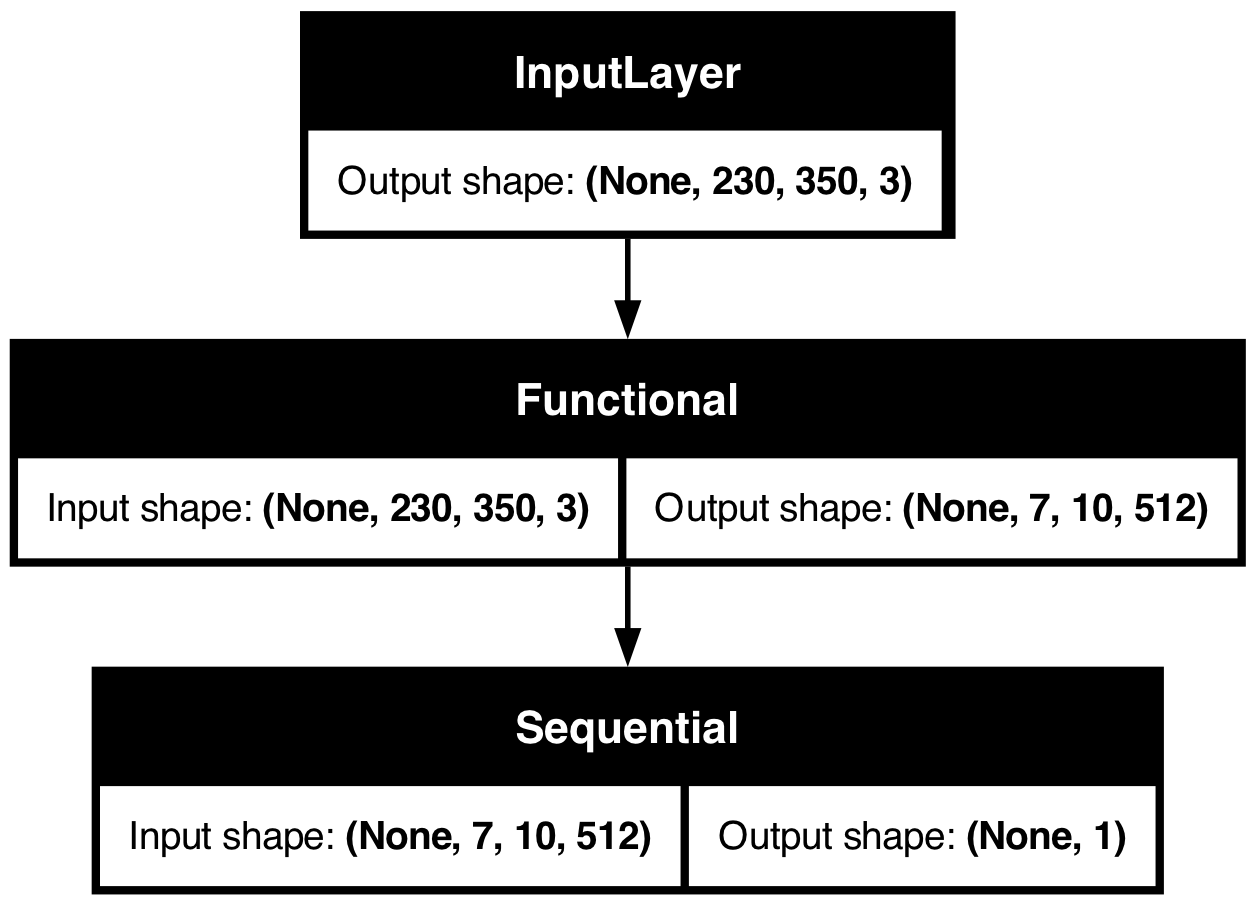

In [38]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

## Phase-1 训练自定义层
- 冻结所有权重

**训练**

In [39]:
# 创建一个 Adam 优化器实例，指定的初始学习率
base_learning_rate = 0.001
optimizer = make_optimizer(base_learning_rate)
# 冻结预训练模型权重
base_model.trainable = False
# 编译模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [40]:
loss0, accuracy0 = model.evaluate(val_dataset, steps=len(val_df) // batch_size)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

/Users/weichen/Desktop/GraduationProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accuracy: 0.3095 - loss: 0.7959
initial loss: 0.80
initial accuracy: 0.31


In [41]:
# 初始训练轮次
initial_epochs = 10

# 初始阶段的训练
history_initial = model.fit(
    x=train_dataset,  # train_dataset is the generator where included weights.
    steps_per_epoch=len(train_df) // batch_size,  # 一个epoch包含的步骤
    validation_data=val_dataset,  # in validation dataset weights is not included.
    validation_steps=len(val_df) // batch_size,  # 一个epoch的验证步骤
    epochs=initial_epochs,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 91s 456ms/step - accuracy: 0.6113 - loss: 1.2827 - val_accuracy: 0.6485 - val_loss: 0.6030
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 89s 451ms/step - accuracy: 0.7399 - loss: 1.0286 - val_accuracy: 0.7990 - val_loss: 0.4514
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 88s 448ms/step - accuracy: 0.7731 - loss: 0.9420 - val_accuracy: 0.8154 - val_loss: 0.4154
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 85s 432ms/step - accuracy: 0.8025 - loss: 0.8594 - val_accuracy: 0.8255 - val_loss: 0.4027
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 436ms/step - accuracy: 0.8219 - loss: 0.7995 - val_accuracy: 0.8015 - val_loss: 0.4373
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 438ms/step - accuracy: 0.8216 - loss: 0.7840 - val_accuracy: 0.8281 - val_loss: 0.3815
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 438ms/step - accuracy: 0.8270 - loss: 0.7914 - val_accuracy: 0.8205 - val_loss: 0.4110
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 84s 428ms/step - accuracy: 0.8292 - loss: 0

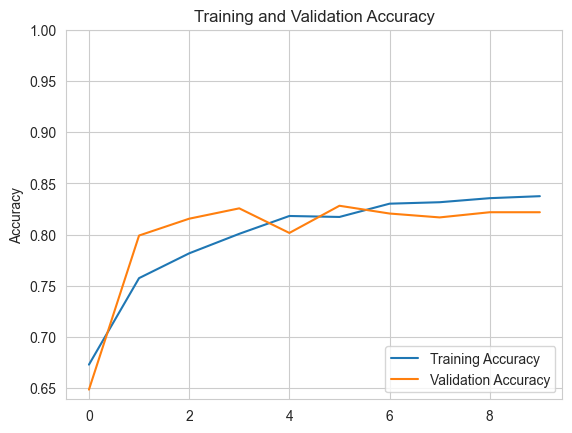

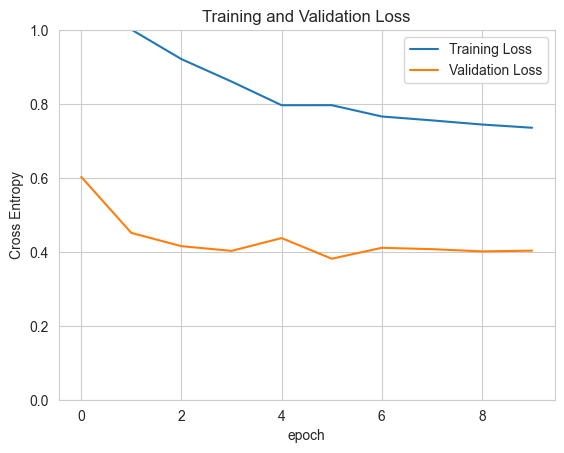

In [42]:
acc = history_initial.history['accuracy']
val_acc = history_initial.history['val_accuracy']

loss = history_initial.history['loss']
val_loss = history_initial.history['val_loss']


plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Phase-2 模型微调
**解冻base model的最顶端若干层，在原有基础上重新训练更新权重**

如果模型包含 Batch Normalization 层，在进行微调时，如果不把 Batch Normalization 层设置成预测模式（也就是说，执行 model(training=False)），那么在微调过程中，Batch Normalization 层的滑动平均的均值和方差会被更新。这可能会破坏预训练模型已经学到的信息，因为这些滑动平均的均值和方差是在预训练过程中利用大量数据学习到的，通常比微调阶段基于少量数据计算出来的均值和方差要准确很多。

所以，进行模型微调时，应该通过传入 training=False 来保持 Batch Normalization 层在预测模式，避免在微调过程中更新它们的非可训练权重。

In [43]:
# 再次解冻模型的一部分层（如最后四层），进行再次训练
for layer in base_model.layers[-4:]:
    layer.trainable = True

# 重新创建优化器，使用更小的lr进行学习
optimizer = make_optimizer(base_learning_rate/10)

# 编译模型
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [44]:
# 微调阶段
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_finetune = model.fit(
    x=train_dataset,  # train_dataset is the generator where included weights.
    steps_per_epoch=len(train_df) // batch_size,  # 一个epoch包含的步骤
    validation_data=val_dataset,  # in validation dataset weights is not included.
    validation_steps=len(val_df) // batch_size,  # 一个epoch的验证步骤
    epochs=total_epochs,
    verbose=1,
    initial_epoch=len(history_initial.epoch),
    callbacks=callbacks
)

Epoch 11/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 102s 507ms/step - accuracy: 0.7445 - loss: 1.2496 - val_accuracy: 0.8913 - val_loss: 0.3016
Epoch 12/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 99s 503ms/step - accuracy: 0.8884 - loss: 0.5606 - val_accuracy: 0.9254 - val_loss: 0.2004
Epoch 13/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 99s 504ms/step - accuracy: 0.9086 - loss: 0.4362 - val_accuracy: 0.9381 - val_loss: 0.1603
Epoch 14/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 99s 501ms/step - accuracy: 0.9321 - loss: 0.3296 - val_accuracy: 0.9507 - val_loss: 0.1475
Epoch 15/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 100s 505ms/step - accuracy: 0.9520 - loss: 0.2424 - val_accuracy: 0.9166 - val_loss: 0.2081
Epoch 16/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 98s 497ms/step - accuracy: 0.9621 - loss: 0.2002 - val_accuracy: 0.9595 - val_loss: 0.1222
Epoch 17/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 101s 514ms/step - accuracy: 0.9724 - loss: 0.1449 - val_accuracy: 0.9494 - val_loss: 0.1371
Epoch 18/60
197/197 ━━━━━━━━━━━━━━━━━━━━ 102s 516ms/step - accuracy: 0.97

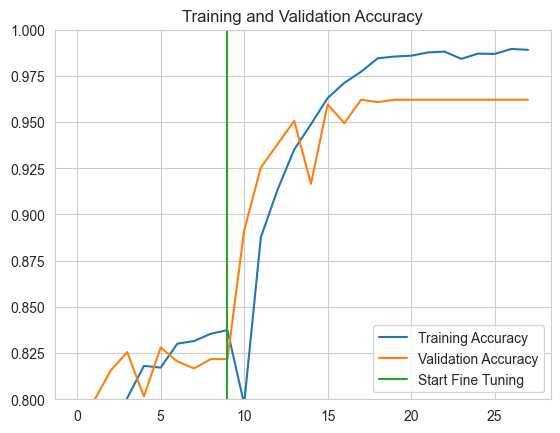

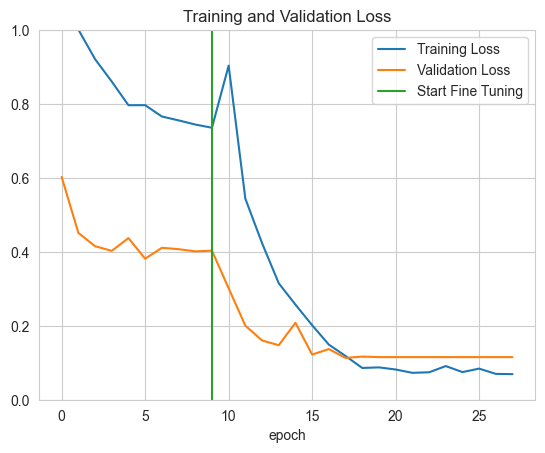

In [45]:
acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']

loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']



plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 模型保存

In [52]:
model.save('vgg16-4level-0.9621.keras')

# 模型测试

In [46]:
loss, accuracy = model.evaluate(test_dataset, steps=len(test_df) // batch_size, verbose=1)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.9648 - loss: 0.1239
Test Loss:  0.11287494748830795
Test Accuracy:  0.9620733857154846


# 模型评估
- 计算精度（Precision）
- 召回率（Recall）
- F1-Score
- 混淆矩阵（Confusion Matrix）
- RUC曲线

In [47]:
predictions = model.predict(test_dataset, steps=len(test_df) // batch_size, verbose=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step


## 标签处理

In [48]:
# 获取真实的类别标签
y_true = test_df['label_encoded'].values

# 对输出的预测结果进行处理，以得到最终的预测类别
y_pred = (predictions > 0.5).astype(int).flatten()

print(len(y_true))
print(len(y_pred))

791
791


## 精度、召回率、F1-score

In [49]:
# 计算精度、召回率、F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# 打印结果
print('Precision: ', precision)
print('Recall: ', recall)
print('F1-score: ', f1)

Precision:  0.6828828828828829
Recall:  0.6979742173112339
F1-score:  0.6903460837887068


## 混淆矩阵

Confusion Matrix: 
 [[ 72 176]
 [164 379]]


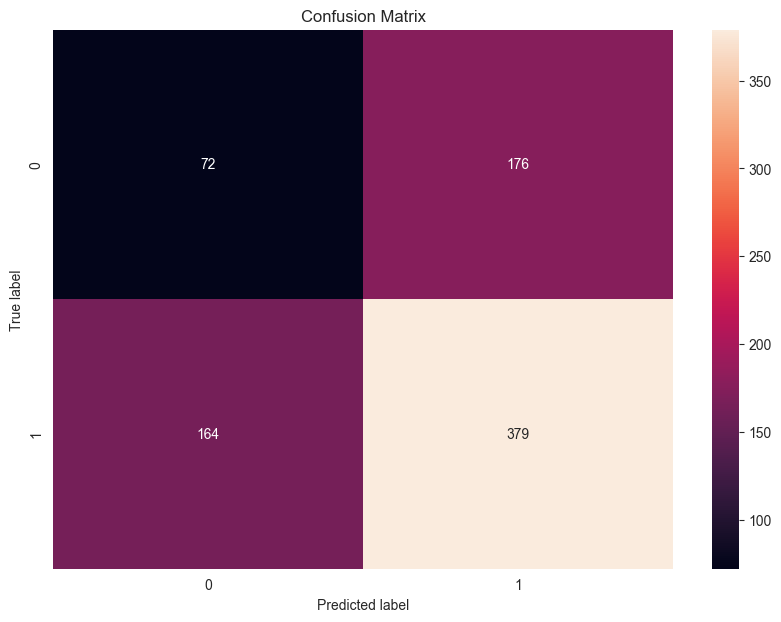

In [50]:
# 计算混淆矩阵
confusion = confusion_matrix(y_true, y_pred)

# 创建一个Matplotlib的图像并设置其大小
plt.figure(figsize=(10,7))

# 在图像上创建一个Seaborn 热力图
sns.heatmap(confusion, annot=True, fmt="d")

# 添加标题和坐标轴标签
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# 打印结果
print('Confusion Matrix: \n', confusion)

# 显示图像
plt.show()

## RUC曲线

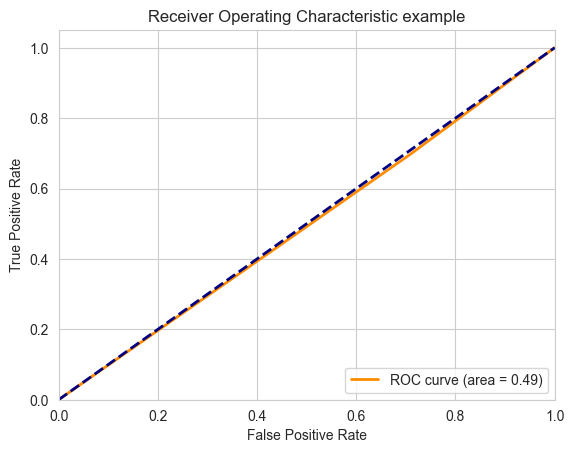

In [51]:
# 计算ROC曲线需要的值：假阳性率(FPR)、真阳性率(TPR)
fpr, tpr, _ = roc_curve(y_true, y_pred)

# 计算曲线下面积(AUC)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
lw = 2  # 线条宽度
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # 绘制对角线（随机预测）
plt.xlim([0.0, 1.0])  # 设置x轴范围
plt.ylim([0.0, 1.05])  # 设置y轴范围
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic example')
plt.legend(loc="lower right")
plt.show()

# 模型部署

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


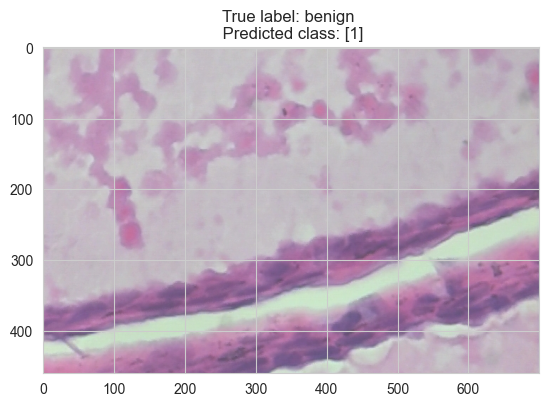

In [62]:
# 使用OpenCV加载图片
img = cv2.imread(test_df["image_path"].iloc[-1])

# 预处理图片用于模型预测
img_model = cv2.resize(img, (350, 230))
img_model = np.expand_dims(img_model, axis=0)

# 使用模型进行预测
preds = model.predict(img_model)
# 对输出的预测结果进行处理，以得到最终的预测类别
predicted_class = (preds > 0.5).astype(int).flatten()

# 将BGR图片转换为RGB图片
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 在使用matplotlib显示图片
plt.imshow(img_rgb)

# 添加标题，包含真实的标签和预测的标签
plt.title(f'True label: {test_df["label"].iloc[-1]} \n Predicted class: {predicted_class}')

# 显示图片和标题
plt.show()